In [3]:
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE, WordPiece
from tokenizers.trainers import BpeTrainer, WordPieceTrainer

In [70]:
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

In [71]:
trainer = WordPieceTrainer(min_frequency=2, special_tokens=["[UNK]", "[SOS]", "[EOS]", "[PAD]"])

In [72]:
files = ["train.csv"]
tokenizer.train(files, trainer)

In [73]:
tokenizer.save("train.json")

In [74]:
tokenizer.get_vocab_size()

7219

In [75]:
output = tokenizer.encode("nishit and karm are doing assignments")
output

Encoding(num_tokens=11, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [76]:
output.tokens

['ni',
 '##sh',
 '##it',
 'and',
 'kar',
 '##m',
 'are',
 'do',
 '##ing',
 'assignment',
 '##s']

### Dataloader

In [4]:
tokenizer = Tokenizer.from_file("train.json")

In [5]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

In [54]:
# data_dir = "/data3/home/karmpatel/dlnlp_assignments/sentiment-classification/dataset"
# split = "train"
# f_name = f"ClassificationDataset-{split}0.xlsx"
# label_dict = {"positive":0, "neutral":1, "negative":2}

In [6]:
# df = pd.read_excel(os.path.join(data_dir, f_name), names=["label", "text"])
# df["text"] = df["text"].apply(lambda x: x.lower())
# df

In [7]:
# id_list = list(df["text"].apply(lambda x: tokenizer.encode(x).ids))

In [8]:
# df["y"] = df["label"].apply(lambda x: label_dict[x])
# df

In [9]:
# labels = df["y"]
# labels

In [73]:
import torch
from torch.nn.utils.rnn import pad_sequence

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchmetrics

device = torch.device("cuda")
cpu_device = torch.device("cpu")

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
class TextClassification(Dataset):
    def __init__(self, data_dir = "/data3/home/karmpatel/dlnlp_assignments/sentiment-classification/dataset"
                ,split = "train",
                label_dict = {"positive":0, "neutral":1, "negative":2}):
        
        f_name = f"ClassificationDataset-{split}0.xlsx"
        self.tokenizer = Tokenizer.from_file("train.json")
        df = pd.read_excel(os.path.join(data_dir, f_name), names=["label", "text"])
        df["text"] = df["text"].apply(lambda x: x.lower())
        self.id_list = list(df["text"].apply(lambda x: torch.Tensor([tokenizer.token_to_id("[SOS]")] + tokenizer.encode(x).ids + [tokenizer.token_to_id("[EOS]")])))  
        df["y"] = df["label"].apply(lambda x: label_dict[x])
        self.labels = df["y"]
    
    def __getitem__(self, idx):
        return self.id_list[idx], self.labels[idx]   
    
    def __len__(self):
        return len(self.labels)
    
    def __collate_fn__(self, batch):
        batch_tensor = pad_sequence([b[0] for b in batch], padding_value=tokenizer.token_to_id("[PAD]")).to(torch.int64)
        return batch_tensor.T, torch.tensor([b[1] for b in batch], dtype=torch.int64)

In [16]:
train_dataset = TextClassification()

In [24]:
B = 512
train_dataloader = DataLoader(train_dataset, batch_size=512, collate_fn=train_dataset.__collate_fn__)
op = next(iter(train_dataloader))

In [25]:
op[0].shape, op[1].shape

(torch.Size([512, 69]), torch.Size([512]))

In [120]:
class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size=64, emb_size=128, n_classes=3):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.classifier = nn.Linear(hidden_size, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
#         x = nn.Dropout(0.2)(self.embeddings(x))
        x = self.relu(self.embeddings(x))
        op, h_last = self.gru(x) # (N, L, H), (1, N ,H)
        h_last = self.relu(h_last)
        logits = self.classifier(h_last.squeeze()) # (N, C)
        return logits
    
    def predict(self, logits):
#         y_hat = torch.argmax(logits, dim=-1)
        y_prob, y_hat = torch.max(torch.softmax(logits, dim=-1), dim=-1)
        return y_hat, y_prob

In [121]:
val_dataset = TextClassification(split="valid")
val_dataloader = DataLoader(val_dataset, batch_size=B, collate_fn=val_dataset.__collate_fn__)

In [122]:
# logits  = model(op[0])
# logits.shape

In [123]:
# y, p = model.predict(logits)
# y, p

In [124]:
model = Model(train_dataset.tokenizer.get_vocab_size()).to(device)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1,1,5], dtype=torch.float32).to(device))
opt  = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [125]:
E = 150
tq_obj = tqdm(range(E))
train_losses, val_losses = [], []
for i,epoch in enumerate(tq_obj):
    model.train()
    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
#         print(loss)
        tq_obj.set_description_str(f"{i+1}/{E} loss:{loss}")
        train_losses.append(loss.detach().to(cpu_device))
    
    pred, target = [], [] 
    with torch.no_grad():
        model.eval()

        for x,y in val_dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss = loss_fn(logits, y)
            val_losses.append(val_loss.detach().to(cpu_device))
            y_hat, p = model.predict(logits)
            pred.extend(y_hat.detach().to(cpu_device))
            target.extend(y.detach().to(cpu_device))
        
        pred = torch.tensor(pred)
        target = torch.tensor(target)
        acc = torchmetrics.Accuracy(task="multiclass", num_classes=3)(pred, target)
        
    tq_obj.set_description_str(f"{i+1}/{E} acc: {acc} loss:{torch.round(loss)} val loss: {torch.round(val_loss)}")

150/150 acc: 0.6464226245880127 loss:1.0 val loss: 1.0: 100%|██████████████████████| 150/150 [00:15<00:00,  9.68it/s]


In [126]:
torchmetrics.ConfusionMatrix(task="multiclass", num_classes=3)(pred, target)

tensor([[  0, 387,   0],
        [  0, 777,   0],
        [  0,  38,   0]])

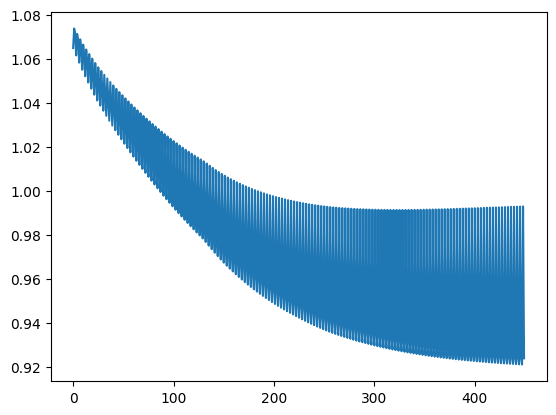

In [127]:
plt.plot(val_losses)

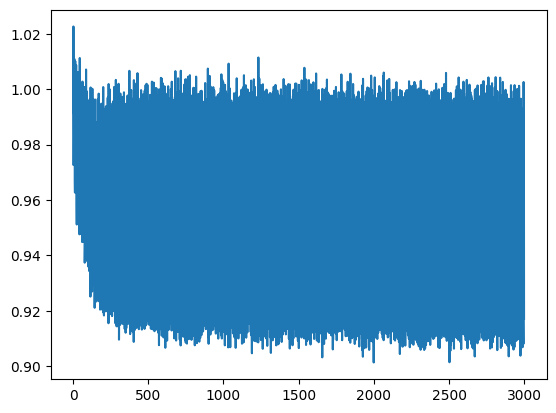

In [111]:
plt.plot(train_losses)

In [180]:
# summary(model, input_size=op[0].shape, device="cpu")

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)